In [1]:
import pandas as pd, numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import os
import torch
import torchaudio
from torch.utils.data import Dataset
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
exam_results = pd.DataFrame(pd.read_csv("../statistics_data/exam_results.csv", dtype = {0:"string"}))
post_exam_survey = pd.DataFrame(pd.read_csv("../statistics_data/post_exam_survey.csv", dtype = {0:"string", 1:"int"}))

In [3]:
merged_df = pd.merge(exam_results, post_exam_survey.rename(columns={
    "2.1:": "2.1_pe",
    "2.2:": "2.2_pe",
    "2.3:": "2.3_pe",
    "2.4:": "2.4_pe",
    "2.5:": "2.5_pe"
}), on="Participant ID:")
merged_df.head()

# Calculation of the average score in percent for each task
max_points = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 6, 3, 3, 4, 4, 4, 10]
column_names = ["1.1:", "1.2:", "1.3:", "1.4:", "1.5:", "1.6:", "1.7:", "1.8:", "1.9:", "1.10:", "2.1:", "2.2:", "3.1:", "3.2:", "3.3:", "3.4:", "3.5:", "4.1:"]

df_max_points = pd.DataFrame({
    'Aufgabe': column_names,
    'Maximale Punktzahl': max_points
})
df_max_points.index = pd.RangeIndex(start=1, stop=len(max_points) + 1, step=1)

avg_percentages = {}
for idx, row in df_max_points.iterrows():
    col_name = row['Aufgabe']
    max_point = row['Maximale Punktzahl']
    avg_percentage = exam_results[col_name].mean() / max_point  # Calculate average share
    avg_percentages[col_name] = avg_percentage * 100  # Convert to percentage

# Directory for the saved images
output_dir = '../images'

# Function for saving the graphics
def save_and_download_plot(file_name, plot_function):
    local_path = os.path.join(output_dir, file_name)
    plot_function()
    plt.savefig(local_path, dpi=600)  # Saving the diagram
    plt.show()

In [4]:
# Define Parameters
ANNOTATIONS_FILE = "../all_data/metadata/spikerbox_recordings.csv"
AUDIO_DIR = "../all_data/files"
SAMPLE_RATE = 10000
NUM_SAMPLES = 9600

In [5]:
class SpikerboxRecordings(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        signal = self._make_log_mels(signal)
        signal = self._adjust_mel_width_if_necessary(signal, 96)

        # Flatten the signal to a 1D numpy array
        signal = signal.flatten().cpu().numpy()  # Convert to numpy array

        return signal, label

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _make_log_mels(self, signal):
        return torchaudio.transforms.AmplitudeToDB().to(self.device)(signal)

    def _adjust_mel_width_if_necessary(self, log_mel_spectrogram, width):
        if log_mel_spectrogram.shape[-1] < width:
            pad_width = width - log_mel_spectrogram.shape[-1]
            log_mel_spectrogram = torch.nn.functional.pad(log_mel_spectrogram, (0, pad_width))
        elif log_mel_spectrogram.shape[-1] > width:
            log_mel_spectrogram = log_mel_spectrogram[:, :, :width]
        return log_mel_spectrogram

In [6]:
exam_results.head()

,Participant ID:,1.1:,1.2:,1.3:,1.4:,1.5:,1.6:,1.7:,1.8:,1.9:,...,3.2:,3.3:,3.4:,3.5:,Sum 3:,4.1:,Sum 4:,Sum All:,Norm:,Bin:
0,0001,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,12.5,0.25,5.0
1,0002,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.5,0.0,4.5,7.0,7.0,19.0,0.38,8.0
2,0003,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,4.0,0.0,7.0,7.5,7.5,22.0,0.44,9.0
3,0004,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,3.0,8.0,8.0,16.5,0.33,7.0
4,0005,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,2.0,9.0,9.0,17.5,0.35,7.0


In [7]:
post_exam_survey.head()

,Participant ID:,Age:,Gender:,2.1:,2.2:,2.3:,2.4:,2.5:,Treatment:,Exam Time:,Location:
0,0001,22,Female,4.0,3.0,35.0,6.0,1.0,0.0,0:14:00,Cologne
1,0002,26,Male,3.0,3.0,40.0,3.0,1.0,0.0,0:24:00,Cologne
2,0003,42,Male,3.0,3.0,20.0,3.0,2.0,0.0,0:17:00,Cologne
3,0004,23,Female,3.0,3.0,25.0,1.0,2.0,0.0,0:25:00,Cologne
4,0005,19,Female,6.0,4.0,15.0,1.0,1.0,0.0,0:15:00,Cologne


In [8]:
merged_df.head()

,Participant ID:,1.1:,1.2:,1.3:,1.4:,1.5:,1.6:,1.7:,1.8:,1.9:,...,Age:,Gender:,2.1_pe,2.2_pe,2.3_pe,2.4_pe,2.5_pe,Treatment:,Exam Time:,Location:
0,0001,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,22,Female,4.0,3.0,35.0,6.0,1.0,0.0,0:14:00,Cologne
1,0002,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,26,Male,3.0,3.0,40.0,3.0,1.0,0.0,0:24:00,Cologne
2,0003,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,42,Male,3.0,3.0,20.0,3.0,2.0,0.0,0:17:00,Cologne
3,0004,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,23,Female,3.0,3.0,25.0,1.0,2.0,0.0,0:25:00,Cologne
4,0005,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,19,Female,6.0,4.0,15.0,1.0,1.0,0.0,0:15:00,Cologne


In [9]:
# Define the variables of interest
variables = ['Age:', '2.1_pe', '2.2_pe', '2.3_pe', 'Norm:']

# Initialize result DataFrame
results = pd.DataFrame(columns=['Variable', 'Mean', 'SD', 'Range'])

# Perform calculations
for var in variables:
    mean = merged_df[var].mean()
    sd = merged_df[var].std()
    range_ = merged_df[var].max() - merged_df[var].min()
    new_row = pd.DataFrame({'Variable': [var], 'Mean': [mean], 'SD': [sd], 'Range': [range_]})
    results = pd.concat([results, new_row], ignore_index=True)

# Output of the results
print(results)

  Variable       Mean         SD Range
0     Age:  22.833333   4.434064    24
1   2.1_pe   4.333333   1.604591   6.0
2   2.2_pe   3.500000   0.572351   2.0
3   2.3_pe  32.433333  13.454094  65.0
4    Norm:   0.342000   0.087588  0.28


In [10]:
# Histogram for age distribution
def plot_age_distribution():
    plt.figure(figsize=(10, 6))
    plt.hist(post_exam_survey['Age:'], bins=range(post_exam_survey['Age:'].min(), post_exam_survey['Age:'].max() + 1), edgecolor='black')
    plt.title('Distribution of Age')
    plt.xlabel('Age')
    plt.ylabel('Number of Participants')
    plt.grid(axis='y', alpha=0.75)

  # Bar chart for gender distribution
def plot_gender_distribution():
    gender_counts = post_exam_survey['Gender:'].value_counts(normalize=True) * 100
    plt.figure(figsize=(10, 6))
    gender_counts.plot(kind='bar', edgecolor='black')
    plt.title('Distribution of Gender')
    plt.xlabel('Gender')
    plt.ylabel('Percent')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

# Bar chart for treatment distribution
def plot_treatment_distribution():
    post_exam_survey['Treatment_Label'] = post_exam_survey['Treatment:'].map({0: 'Control', 1: 'Treatment'})
    treatment_counts = post_exam_survey['Treatment_Label'].value_counts(normalize=True) * 100
    plt.figure(figsize=(10, 6))
    treatment_counts.plot(kind='bar', edgecolor='black')
    plt.title('Distribution of Treatment and Control Group')
    plt.xlabel('Treatment/Control')
    plt.ylabel('Percent')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

# Histogram for stress level during the exam
def plot_stress_level():
    stress_counts = post_exam_survey['2.1:'].value_counts(normalize=True) * 100
    sorted_counts = stress_counts.sort_index()
    plt.figure(figsize=(10, 6))
    sorted_counts.plot(kind='bar', edgecolor='black')
    plt.title('Distribution of Stress Levels During the Exam')
    plt.xlabel('Stress Level')
    plt.ylabel('Percent')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

# Bar chart for expected exam performance
def plot_performance_expectation():
    custom_labels = {
        1: 'Very good',
        2: 'Good',
        3: 'Mediocre',
        4: 'Bad',
        5: 'Very bad'
    }

    performance_counts = post_exam_survey['2.2:'].value_counts(normalize=True) * 100
    sorted_counts = performance_counts.sort_index()
    sorted_counts.index = sorted_counts.index.map(custom_labels)
    plt.figure(figsize=(10, 6))
    sorted_counts.plot(kind='bar', edgecolor='black')
    plt.title('Distribution of the Expected Examination Performance')
    plt.xlabel('Expectations of Participants')
    plt.ylabel('Percent')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

# Histogram for the working hours
def plot_hours_per_week():
    post_exam_survey['2.3:'] = pd.to_numeric(post_exam_survey['2.3:'], errors='coerce')
    post_exam_survey.dropna(subset=['2.3:'], inplace=True)
    total_count = len(post_exam_survey)
    hours_counts = post_exam_survey['2.3:'].value_counts(normalize=True) * 100
    sorted_counts = hours_counts.sort_index()
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_counts.index, sorted_counts.values, align='center', width=2.0, edgecolor='black')
    plt.title('Distribution of Study/Work Hours per Week')
    plt.xlabel('Working Hours per Week')
    plt.ylabel('Percent')
    plt.grid(axis='y', alpha=0.75)

# Bar chart for the educational qualification
def plot_highest_education_level():
    education_labels = {
        1: 'Secondary education',
        2: 'Post-secondary education',
        3: 'Bachelor´s degree',
        4: 'Master´s degree',
        5: 'Doctorate'
    }

    post_exam_survey['2.4:'] = post_exam_survey['2.4:'].map(education_labels)
    total_count = len(post_exam_survey)
    education_counts = post_exam_survey['2.4:'].value_counts(normalize=True) * 100
    sorted_counts = education_counts.sort_index()
    plt.figure(figsize=(10, 6))
    sorted_counts.plot(kind='bar', edgecolor='black')
    plt.title('Distribution of the Highest Educational Qualification')
    plt.xlabel('Educational Qualifications of the Participants')
    plt.ylabel('Percent')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

# Bar chart on agreement with the health condition
def plot_health():
    agreement_labels = {
        1: 'Totally agree',
        2: 'Agree',
        3: 'Neutral',
        4: 'Disagree',
        5: 'Totally disagree'
    }

    post_exam_survey['2.5:'] = post_exam_survey['2.5:'].map(agreement_labels)
    total_count = len(post_exam_survey)
    agreement_counts = post_exam_survey['2.5:'].value_counts(normalize=True) * 100
    sorted_counts = agreement_counts.sort_index()
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_counts.index, sorted_counts.values, edgecolor='black')
    plt.title('Distribution of Agreement With the Statement on Health Condition')
    plt.xlabel('Approval of Statement')
    plt.ylabel('Percent')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

# Color differentiation for treatment and control
# Point distribution in treatment and control

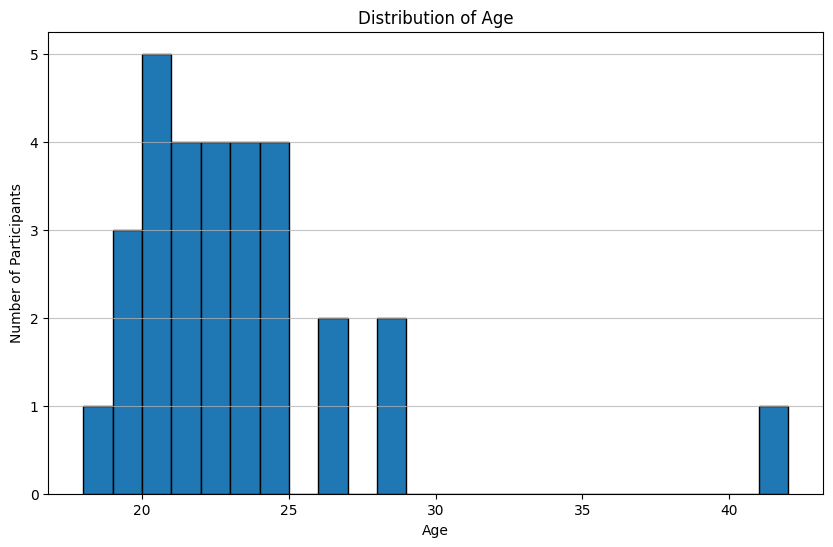

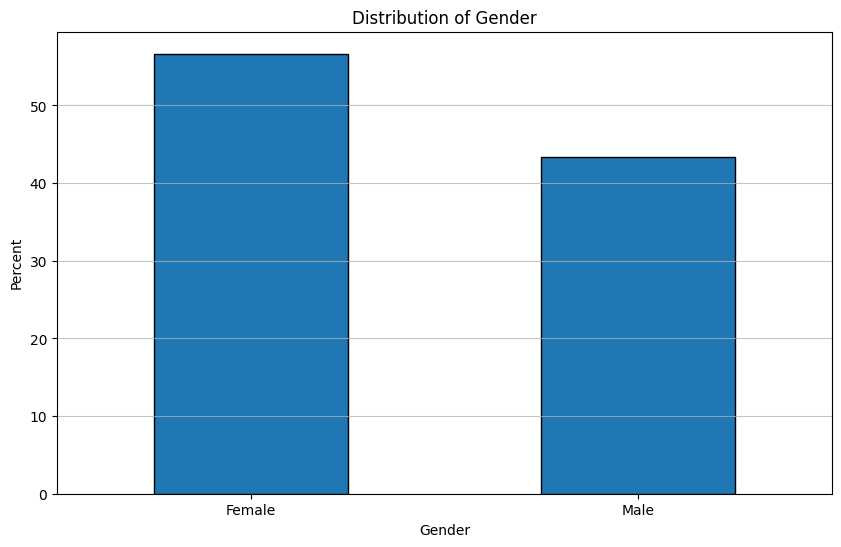

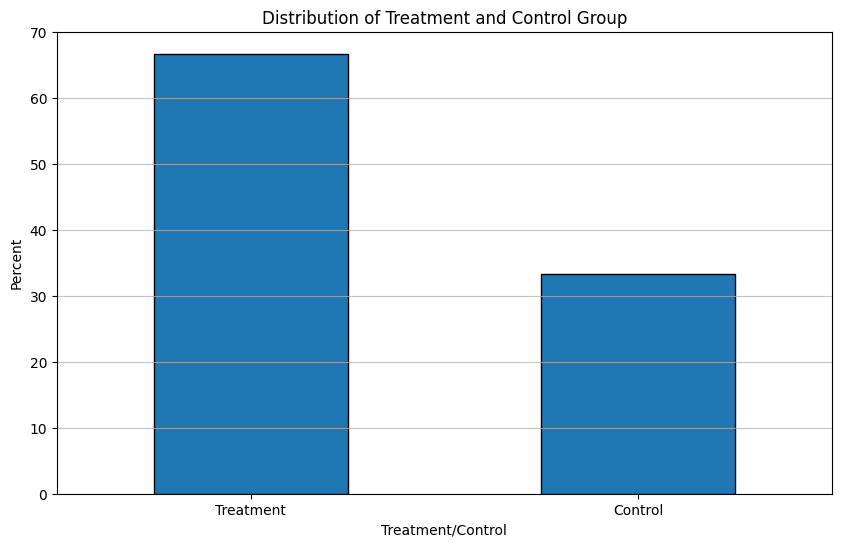

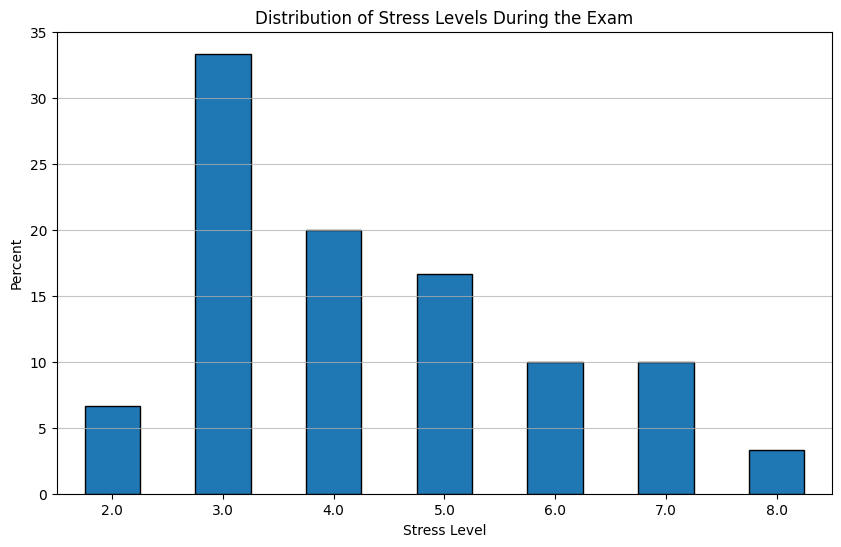

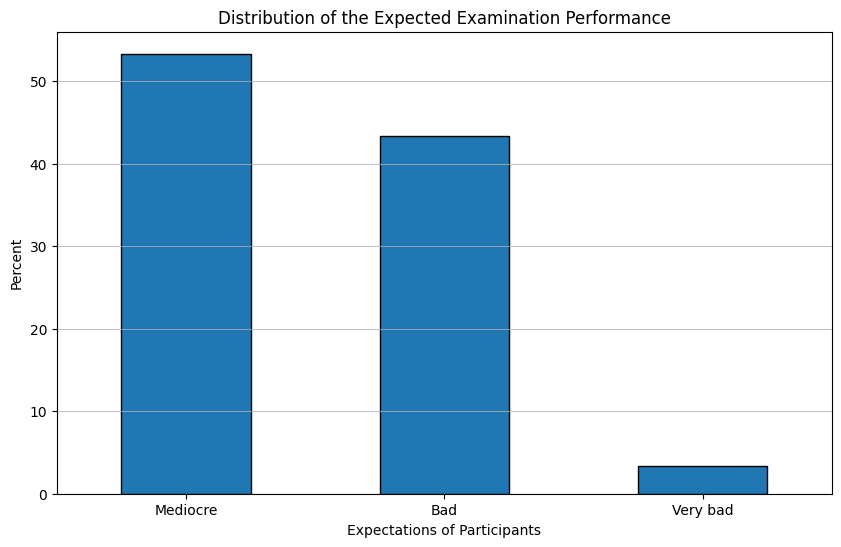

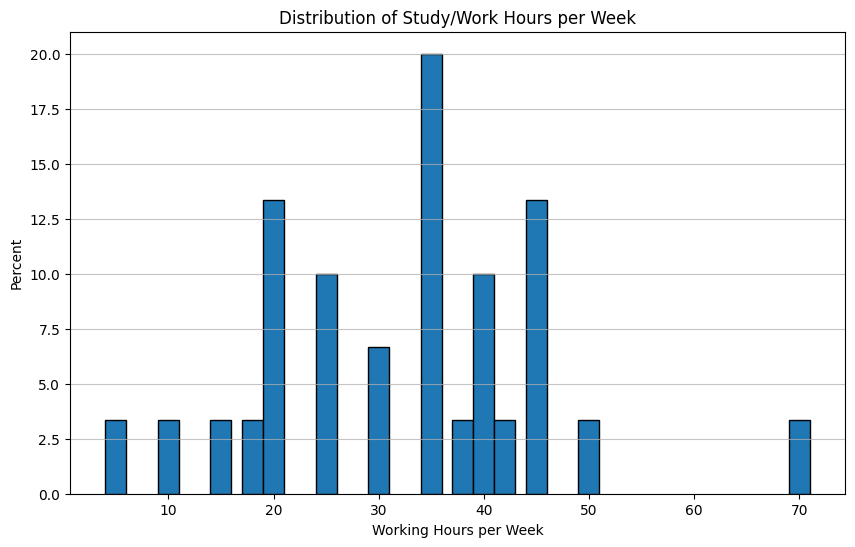

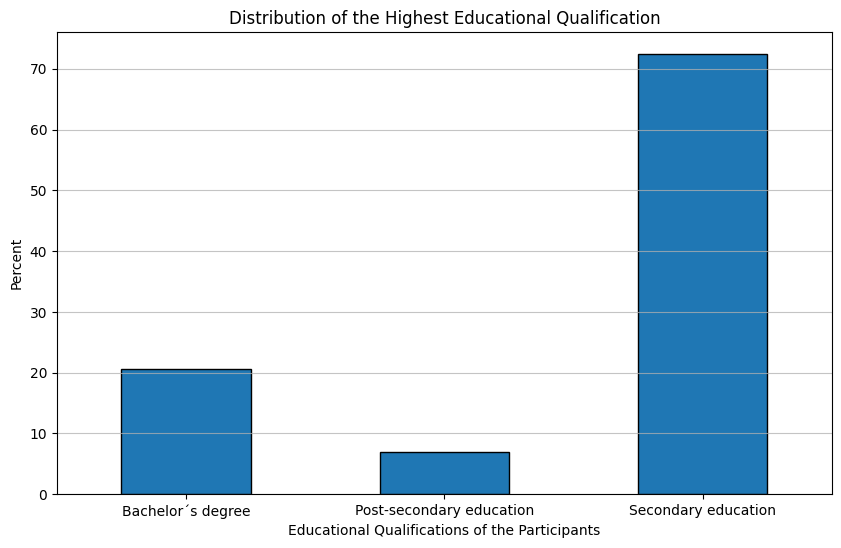

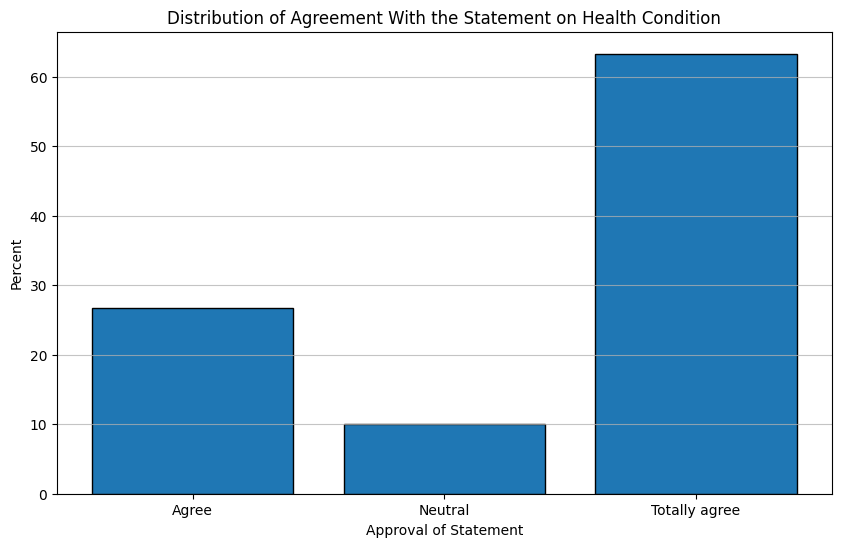

In [11]:
save_and_download_plot('age_dist.png', plot_age_distribution)
save_and_download_plot('gender_dist.png', plot_gender_distribution)
save_and_download_plot('group_dist.png', plot_treatment_distribution)
save_and_download_plot('stress_level_dist.png', plot_stress_level)
save_and_download_plot('performance_dist.png', plot_performance_expectation)
save_and_download_plot('hours_dist.png', plot_hours_per_week)
save_and_download_plot('educ_dist.png', plot_highest_education_level)
save_and_download_plot('health_dist.png', plot_health)

In [12]:
# Distribution of grades
def plot_grade_distribution():
    normalized_results = (exam_results['Sum 1:'] + exam_results['Sum 2:']) / 20  # Normalisierung auf eine Skala von 0 bis 1
    plt.figure(figsize=(10, 6))
    plt.hist(normalized_results, bins=np.arange(0, 1.1, 0.1), edgecolor='black')
    plt.xlabel('Normalized Grade')
    plt.ylabel('Number of Participants')
    plt.title('Grade Distribution')
    plt.grid(axis='y', alpha=0.75)

# Line graph of average scores for each task
def plot_average_task_points():
    plt.figure(figsize=(12, 6))
    plt.plot(avg_percentages.keys(), avg_percentages.values(), marker='o', linestyle='-', color='b', label='Average Share (%)')
    plt.xticks(rotation=45)
    plt.title('Average Percentage of Points for Each Task')
    plt.xlabel('Tasks')
    plt.ylabel('Average Percentage of Points (%)')
    plt.grid(True)
    plt.tight_layout()

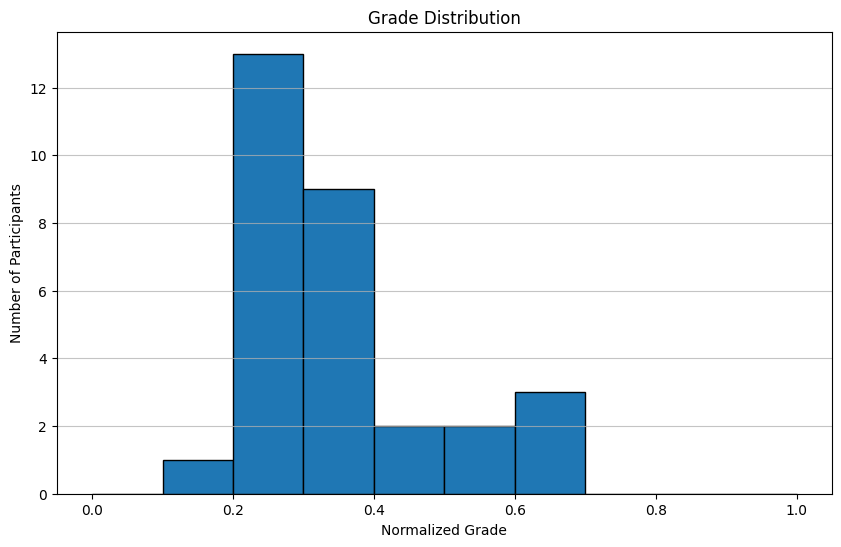

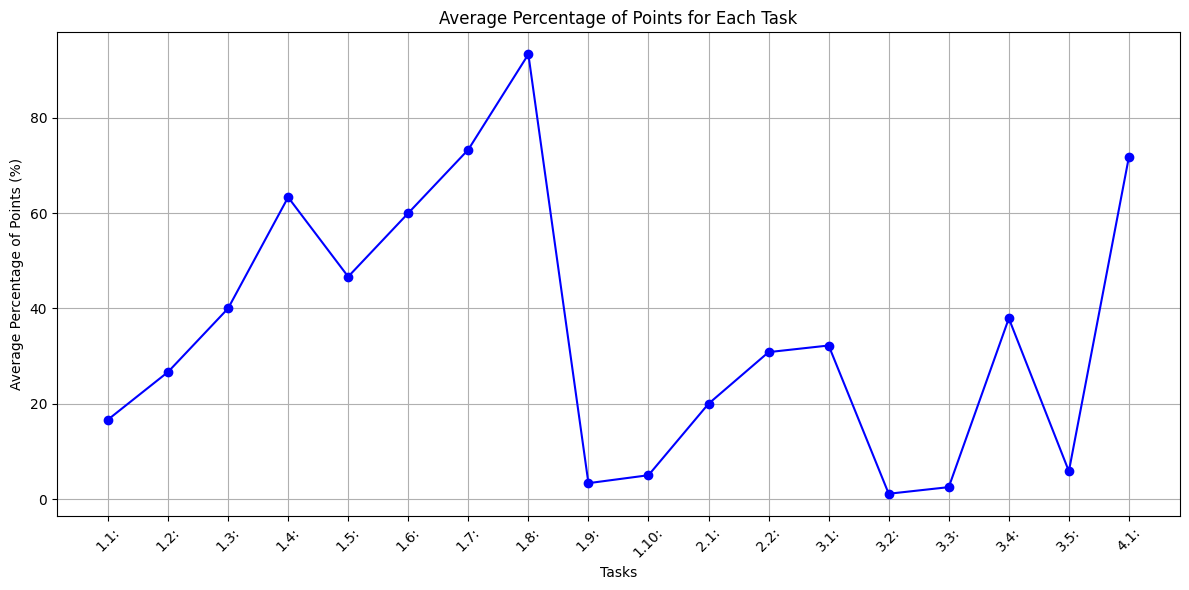

In [13]:
save_and_download_plot('plot_grade_dist.png', plot_grade_distribution)
save_and_download_plot('plot_average_task_points.png', plot_average_task_points)

In [14]:
# T-test for notes
normalized_result = merged_df['Norm:']
treatment = merged_df['Treatment:']

# Extract data from the treatment and control groups
treatment_group = merged_df[merged_df['Treatment:'] == 1]['Norm:']
control_group = merged_df[merged_df['Treatment:'] == 0]['Norm:']

# Test for normal distribution
shapiro_treatment = stats.shapiro(treatment_group)
shapiro_control = stats.shapiro(control_group)

# Test for variance homogeneity
levene_test = stats.levene(treatment_group, control_group)

# Two-sample t-test
ttest_result = stats.ttest_ind(treatment_group, control_group)

# Print results
print(f"Shapiro-Wilk test for the treatment group: {shapiro_treatment}")
print(f"Shapiro-Wilk test for the control group: {shapiro_control}")
print(f"Levene test for variance homogeneity: {levene_test}")
print(f"Two-sample t-test: {ttest_result}")

Shapiro-Wilk test for the treatment group: ShapiroResult(statistic=0.9183274756630452, pvalue=0.09200965009346933)
Shapiro-Wilk test for the control group: ShapiroResult(statistic=0.9747317663636359, pvalue=0.9309191621173085)
Levene test for variance homogeneity: LeveneResult(statistic=1.0674486803519085, pvalue=0.31036421852988605)
Two-sample t-test: TtestResult(statistic=-0.2174280053938474, pvalue=0.8294514698398882, df=28.0)


A T-test requires normal distribution of the two groups, as well as homoscedasticity - homogeneity of variance:
1. Shapiro-Wilk test: a value greater than .05 would mean that the data are approximately normally distributed.
    * For the treatment group: p-value = 0.092, which indicates that the data do not deviate significantly from the normal distribution (p > 0.05).
    * For the control group: p-value = 0.931, indicating that the data are normally distributed (p > 0.05).
2nd Levene test: If the p-value is greater than 0.05, a homogeneous variance can be assumed.
    * p-value = 0.310, which indicates that the variances between the groups are homogeneous (p > 0.05).
3. two-sample t-test: With a sig. value lower than 0.05, the null hypothesis (There are no differences in the mean values) is rejected.
    * t-statistic = -0.217, p-value = 0.829, which indicates that there is no significant difference between the mean values of the groups (p > 0.05).

In [15]:
# T-test for perceived stress
stress = merged_df['2.1_pe']
treatment = merged_df['Treatment:']

# Extract data from the treatment and control groups
treatment_group = merged_df[merged_df['Treatment:'] == 1]['2.1_pe']
control_group = merged_df[merged_df['Treatment:'] == 0]['2.1_pe']

# Test for normal distribution
shapiro_treatment = stats.shapiro(treatment_group)
shapiro_control = stats.shapiro(control_group)

# Test for variance homogeneity
levene_test = stats.levene(treatment_group, control_group)

# Two-sample t-test
ttest_result = stats.ttest_ind(treatment_group, control_group)

# Print results
print(f"Shapiro-Wilk test for the treatment group: {shapiro_treatment}")
print(f"Shapiro-Wilk test for the control group: {shapiro_control}")
print(f"Levene test for variance homogeneity: {levene_test}")
print(f"Two-sample t-test: {ttest_result}")

# Mann-Whitney U test for stress
statistic, p_value = mannwhitneyu(treatment_group, control_group)

# Print results
print(f"Mann-Whitney-U-Test (MEL): U = {statistic}, p-Wert = {p_value}")

Shapiro-Wilk test for the treatment group: ShapiroResult(statistic=0.948103213225461, pvalue=0.3392138404689082)
Shapiro-Wilk test for the control group: ShapiroResult(statistic=0.7494813633606132, pvalue=0.003517161567352529)
Levene test for variance homogeneity: LeveneResult(statistic=0.6599326599326599, pvalue=0.423437033861349)
Two-sample t-test: TtestResult(statistic=1.5665228015539059, pvalue=0.12845949822921493, df=28.0)
Mann-Whitney-U-Test (MEL): U = 140.0, p-Wert = 0.07445607826143417


A T-test requires normal distribution of the two groups, as well as homoscedasticity - homogeneity of variance:
1. Shapiro-Wilk test: a value greater than .05 would mean that the data are approximately normally distributed.
    * For the treatment group: p-value = 0.339, which indicates that the data do not deviate significantly from the normal distribution (p > 0.05).
    * For the control group: p-value = 0.004, indicating that the data are not normally distributed (p > 0.05).
2nd Levene test: If the p-value is greater than 0.05, a homogeneous variance can be assumed.
    * p-value = 0.423, which indicates that the variances between the groups are homogeneous (p > 0.05).
3. two-sample t-test: With a sig. value lower than 0.05, the null hypothesis (There are no differences in the mean values) is rejected.
    * t-statistic = 1.567, p-value = 0.128, which indicates that there is no significant difference between the mean values of the groups (p > 0.05).

In contrast to parametric tests such as the t-test, the Mann-Whitney U-test does not require a specific distribution of the data.
4. Mann-Whitney U-test: A p-value less than .05 means that the difference is considered statistically significant.
    * U = 140.0, p-value = 0.074, which indicates that there is no significant difference between the groups.

In [16]:
mel_spectogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=400,
    hop_length=160,
    n_mels=64
)


spr = SpikerboxRecordings(
    ANNOTATIONS_FILE,
    AUDIO_DIR,
    mel_spectogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    "cpu"
)

# Test
signal, label = spr[1]
print(signal.shape)
print(label)

(6144,)
0


In [17]:
# T-test for MEL
mfcc_treatment = []
mfcc_control = []

# Iterate through dataset to collect data
for index in range(len(spr)):
    signal, label = spr[index]
    if label == 1:
        mfcc_treatment.append(signal)
    else:
        mfcc_control.append(signal)

# Flatten the lists into one-dimensional numpy arrays for Shapiro-Wilk test
flat_mfccs_treatment = np.concatenate(mfcc_treatment)
flat_mfccs_control = np.concatenate(mfcc_control)

# Shapiro-Wilk tests for normality and Levene's test for homogeneity of variance
shapiro_treatment = stats.shapiro(flat_mfccs_treatment)
shapiro_control = stats.shapiro(flat_mfccs_control)
levene_test = stats.levene(flat_mfccs_treatment, flat_mfccs_control)

# Two-sample t-test
t_stat, p_value = stats.ttest_ind(flat_mfccs_treatment, flat_mfccs_control)

# Print results
print(shapiro_treatment)
print(shapiro_control)
print(levene_test)
print(t_stat, p_value)

ShapiroResult(statistic=0.7215180485820463, pvalue=2.8501652893181855e-147)
ShapiroResult(statistic=0.7133146876116098, pvalue=6.22496315273058e-128)
LeveneResult(statistic=7.581444791063194, pvalue=0.005897812787258577)
-8.297385605002 1.0715804212601496e-16


C:\Users\dsmolin\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 122880.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\dsmolin\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 55296.
  res = hypotest_fun_out(*samples, **kwds)


1. Shapiro-Wilk test: A p-value greater than 0.05 would indicate that the data is approximately normally distributed.
  * For the treatment group (stress level): p-value < 0.0, indicating that the data deviate significantly from the normal distribution (p < 0.05).
  * For the control group (stress level): p-value < 0.0, indicating that the data are not normally distributed (p < 0.05).
2nd Levene test: A p-value greater than 0.05 indicates homogeneous variances between the groups.
  * p-value < 0.0, indicating that the variances between the groups are heterogeneous (p < 0.05).
3. two-sample t-test: A p-value greater than 0.05 leads to the acceptance of the null hypothesis (no differences in the mean values).
  * t-statistic = -8.297, p-value = 1.07e-16, indicating that there is a significant difference between the mean values of the groups (p < 0.05).

In [18]:
# Mann-Whitney-U-Test for MEL
statistic, p_value = mannwhitneyu(flat_mfccs_treatment, flat_mfccs_control)

# Print Results
print(f"Mann-Whitney-U-Test (MEL): U = {statistic}, p-Wert = {p_value}")

Mann-Whitney-U-Test (MEL): U = 3139583638.5, p-Wert = 1.4036951384528757e-152


 A p-value less than 0.05 means that the difference is considered statistically significant.
* U = 3139583370.5, p-value = 1.4026838113193152e-152, which indicates that there is a significant difference between the groups.